#  Analyse spectra holo at AuxTel for Configurations

- version 3 to work with results of postisrccd from usdf


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- Spectractor version 2.5, version of July 2023
- creation date : September 7th  2023
- last update : September 7th 2023


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import sys
print(sys.path)

['/sdf/data/rubin/user/dagoret/AuxTelComm/notebooks_usdf/runspectractor_standalone/2023_09', '/home/d/dagoret/repos/repos_w_2023_35/analysis_tools/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/cp_pipe/g857a3418e4+7df23b908a/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/shapelet/g44018dc512+ea6441928c/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_modelfit/g93c4d6e787+79b822255a/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet_extensions/g9d18589735+d445b4966c/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/proxmin/g33b4157f25/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/scarlet/g63ff1f842d+4083830bf8/lib/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_scarlet/g943cb464a2+f79590064d/python', '/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2

In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [4]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

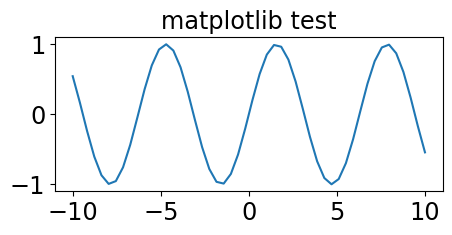

In [5]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.title("matplotlib test")
plt.show()               

In [6]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [7]:
from datetime import datetime,date

In [8]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [9]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [10]:
string_date

'2023-09-07'

In [11]:
from iminuit import Minuit
import iminuit

In [12]:
iminuit.__version__

'2.22.0'

In [13]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters
#dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
import pickle

# Calibration line

In [17]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [18]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_pseudo-postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [19]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [20]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

In [21]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [22]:
# path index for each month
DATE="20230817"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [38]:
version="v7.0"

In [39]:
#Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini']



config_idx = len(list_of_spectractorconfigfiles)-2
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [40]:
configdir 

'config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [41]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [42]:
load_config(configfilename)

In [43]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'FFMv_REBIN2_Janv2023'

## Parameters

In [44]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR ../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR extractor/dispersers/
DISPLAY False
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
LAMBDAS [ 300  301  302  303  304  305  306  307  308  309  310  311  312  313
  314  315  316  317  318  319  320  321  322  323  324  325  326  327
  328  329  330  331  332  333  334  335  336  337  338  339  340  341
  342  343  344  345  346  347  348  349  350  351  352  353  354  355
  356  357  358  359  360  361  362  363  364  365  366  367  368  369
  370  371  372  373  374  375  376  377  378  379  380  381  382  383
  384  385  386  387  388  389  390  391  392  393  394  395  396  397
  3

# Path

In [45]:
def GetPaths(computer_name):
    """
    """
    
    if computer_name == "HOSTCC":
        
        path_auxtel="/sps/lsst/groups/auxtel"
        path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
    
        path_images=os.path.join(path_auxtel,"data/hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
    elif computer_name == "LAPTOP1":
        path_auxtel="/Users/dagoret/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        
        
    elif computer_name == "WORKIMAC":
        path_auxtel="/Users/sylvie/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
            
            
        
    elif computer_name == "HOMEIMAC":
        path_auxtel="/Volumes/Backup2020/DATA"
        path_spectractor=os.path.join(path_auxtel,"MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(".","config")
        path_images=os.path.join(path_auxtel,"hack_usdf/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        
        # /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor
        
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"AuxTelDATA2023/data/2023/OutputSpectractor/"+imagemode)
            
    elif computer_name == "USDF":
        path_auxtel="/home/d/dagoret/rubin-user/DATA"
        path_spectractor=os.path.join("/home/d/dagoret","repos/repos_w_2023_35/Spectractor")
        path_spectractor_config=os.path.join(".","config")
        path_images=os.path.join(path_auxtel,"AuxtelData2023/my_postisrccd_img_forspectractor_2023/"+filterdispersername+"/"+DATE)
        
        # /Volumes/Backup2020/DATA/AuxTelDATA2023/data/2023/OutputSpectractor
        
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"AuxtelData2023/OutputSpectractor/"+imagemode)     
        
    else:
        print(f"Unknown computer {computer_name}")
        
              
    return path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor
        

In [46]:
mycomputer_name = "USDF"
path_auxtel,path_spectractor,path_spectractor_config,path_images,path_toptoptopoutput_spectractor, path_toptopoutput_spectractor, path_topoutput_spectractor, path_output_spectractor  = GetPaths(mycomputer_name)

In [47]:
path_output_spectractor

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817'

In [48]:
! ls -l $path_output_spectractor

total 0
drwxr-sr-x 1 dagoret rubin_users 0 Sep  6 14:00 2023081700144
drwxr-sr-x 1 dagoret rubin_users 0 Sep  6 12:37 2023081700147


In [49]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [50]:
load_config(configfilename)

## Logbook for file selection

In [51]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [52]:
df=pd.read_csv(filename_logbook,index_col=0)

In [53]:
pd.set_option('display.max_rows', None)

In [54]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2023-08-17T23:42:04.293,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700144_pseudo-postisrccd.fits,144,HD185975,empty_1,holo4_003,1.903331,30.0,...,4.0500,39.362499,5.2542,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2023-08-17T23:43:56.231,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700147_pseudo-postisrccd.fits,147,HD185975,empty_1,holo4_003,1.902132,30.0,...,4.1500,34.474998,4.4202,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2023-08-17T23:44:39.311,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700148_pseudo-postisrccd.fits,148,HD185975,empty_1,holo4_003,1.901747,30.0,...,4.1500,34.150002,5.0874,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2023-08-18T00:01:25.370,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700166_pseudo-postisrccd.fits,166,HD146233,empty_1,holo4_003,1.096033,30.0,...,4.1875,28.112499,3.9198,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2023-08-18T00:02:08.272,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700167_pseudo-postisrccd.fits,167,HD146233,empty_1,holo4_003,1.096667,30.0,...,4.1500,29.125000,4.7538,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2023-08-18T00:03:54.913,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700170_pseudo-postisrccd.fits,170,HD146233,empty_1,holo4_003,1.098255,30.0,...,4.0500,31.025000,4.4202,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2023-08-18T00:04:37.826,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700171_pseudo-postisrccd.fits,171,HD146233,empty_1,holo4_003,1.098928,30.0,...,4.0500,32.037498,4.5870,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2023-08-18T00:09:47.082,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700180_pseudo-postisrccd.fits,180,HD146233,empty_1,holo4_003,1.104090,30.0,...,4.2250,24.225000,4.4202,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2023-08-18T00:10:29.990,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700181_pseudo-postisrccd.fits,181,HD146233,empty_1,holo4_003,1.104852,30.0,...,4.1500,25.075001,5.0040,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2023-08-18T00:12:16.474,/home/d/dagoret/rubin-user/DATA/AuxtelData2023...,exposure_2023081700184_pseudo-postisrccd.fits,184,HD146233,empty_1,holo4_003,1.106748,30.0,...,3.9500,28.250000,4.0866,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [55]:
df_good=df
df_good["quality"] = 1

In [56]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2023081700144_pseudo-postisrccd.fits
exposure_2023081700147_pseudo-postisrccd.fits
exposure_2023081700148_pseudo-postisrccd.fits
exposure_2023081700166_pseudo-postisrccd.fits
exposure_2023081700167_pseudo-postisrccd.fits
exposure_2023081700170_pseudo-postisrccd.fits
exposure_2023081700171_pseudo-postisrccd.fits
exposure_2023081700180_pseudo-postisrccd.fits
exposure_2023081700181_pseudo-postisrccd.fits
exposure_2023081700184_pseudo-postisrccd.fits
exposure_2023081700185_pseudo-postisrccd.fits
exposure_2023081700194_pseudo-postisrccd.fits
exposure_2023081700195_pseudo-postisrccd.fits
exposure_2023081700198_pseudo-postisrccd.fits
exposure_2023081700199_pseudo-postisrccd.fits
exposure_2023081700209_pseudo-postisrccd.fits
exposure_2023081700210_pseudo-postisrccd.fits
exposure_2023081700213_pseudo-postisrccd.fits
exposure_2023081700214_pseudo-postisrccd.fits
exposure_2023081700223_pseudo-postisrccd.fits
exposure_2023081700224_pseudo-postisrccd.fits
exposure_2023081700227_pseudo-post

## Selection of Spectractor output files

In [57]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [58]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2023081700144', '2023081700147']
00144
---------------------------------------------
2023081700144  	   00144
2023081700144 is a directory
tagname= 00144
dir_plots is not empty
dir_spectration is not empty
00147
---------------------------------------------
2023081700147  	   00147
2023081700147 is a directory
tagname= 00147
dir_plots is not empty
dir_spectration is not empty
-----------------------------------------------------------------
Full list of Exposures : .......................['00144', '00147']
Full list of Exposures without output dir: .....[]
Full list of Exposures with output dir: ....... ['00144', '00147']
Full list of Exposures with output plots: ..... ['00144', '00147']
Full list of Exposures with output spectra: ....['00144', '00147']
Total number of exposures : .....................2
Total number of exposures without dir : .........0
Total number of exposures with dir :.............2
Total number of exposures with plots : ..........2
Total nu

In [59]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec', '/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700147/basespec']


In [60]:
config

'./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini'

## Extraction of spectra

In [61]:
all_files_spectra = []
#all_files_spectrogram = []
all_files_lines = []
#all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            #the_file_spectrogram=the_file_spectrum.replace("_spectrum.fits","_spectrogram.fits")
            #all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            #the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            #all_files_table.append(the_file_table)
    

In [62]:
#all_files_spectrogram

In [63]:
all_files_spectra[:3]

['/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec/exposure_2023081700144_pseudo-postisrccd_spectrum.fits',
 '/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700147/basespec/exposure_2023081700147_pseudo-postisrccd_spectrum.fits']

In [64]:
#all_files_spectrogram[:3]

In [65]:
all_files_lines[:3]

['/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec/exposure_2023081700144_pseudo-postisrccd_lines.csv',
 '/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700147/basespec/exposure_2023081700147_pseudo-postisrccd_lines.csv']

In [66]:
#all_files_table[:3] 

## Selection of good spectra

In [67]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [68]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

In [94]:
parameters.LSST_SAVEFIGPATH = "."
parameters.debug= False
parameters.verbose= False
parameters.display= False
parameters.LIVE_FIT=False

In [95]:
parameters.LSST_SAVEFIGPATH

'.'

0 ) exposure_2023081700144_pseudo-postisrccd_spectrum.fits   /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec/exposure_2023081700144_pseudo-postisrccd_spectrum.fits
[Errno 2] No such file or directory: './figures_process_20230817_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_1/HD185975_spectrum.pdf'


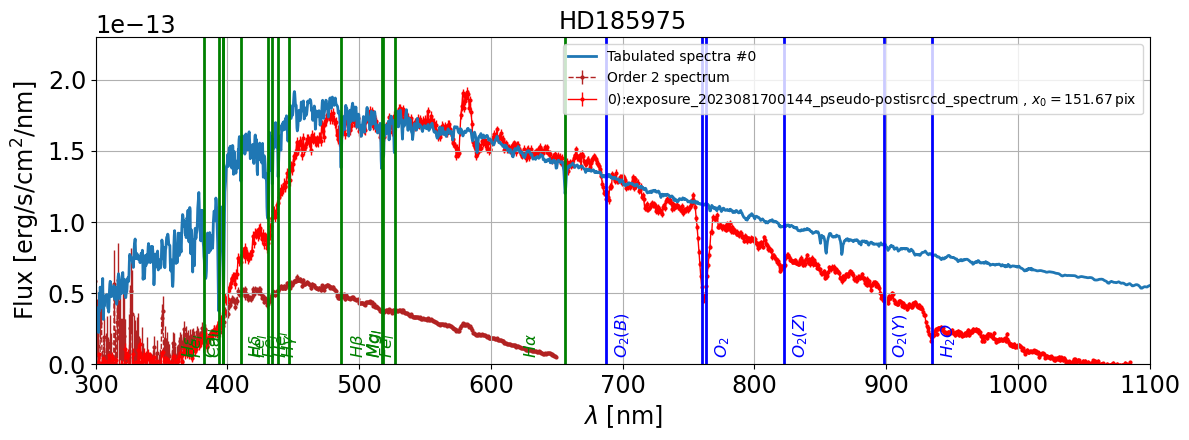

In [96]:
%matplotlib inline
idx=0


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
#s=Spectrum(fullfilename, config=config,fast_load=False)
s=Spectrum(fullfilename,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
try:
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
except Exception as exc:
    print(exc)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

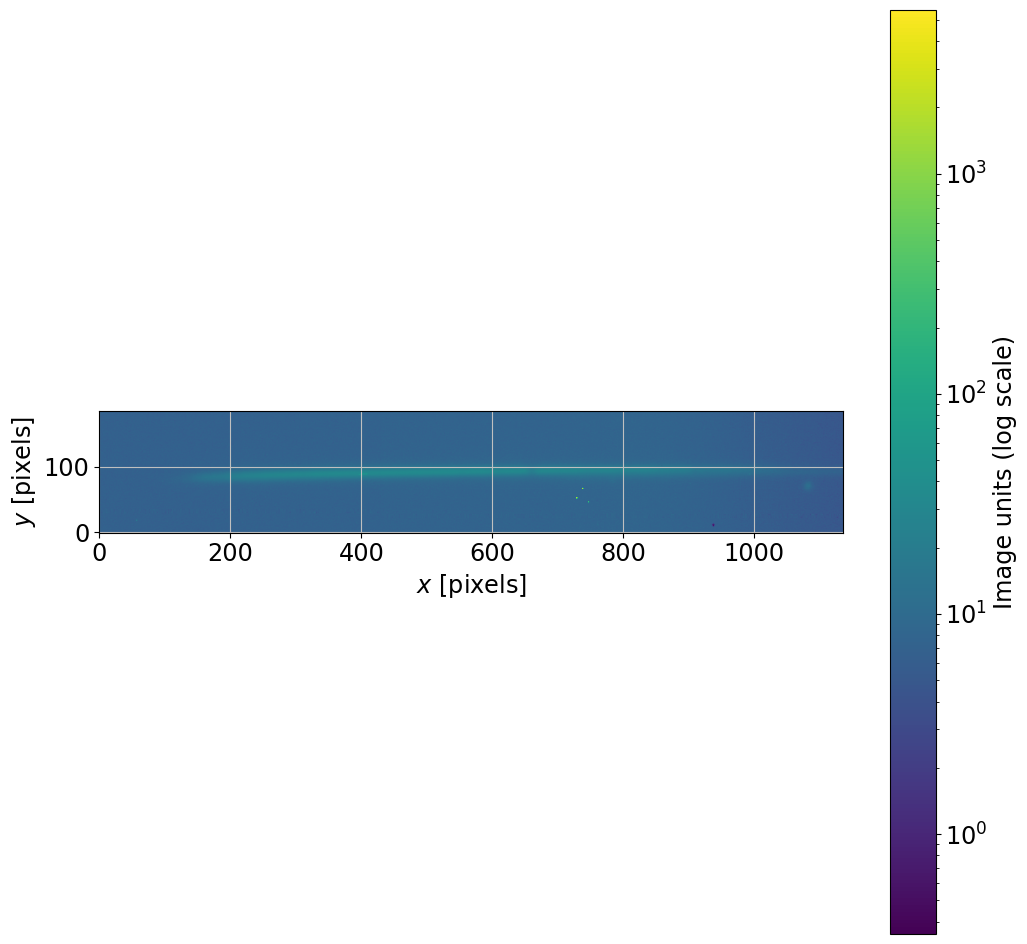

In [97]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
try:
    s.plot_spectrogram(ax=ax,scale="log")
except Exception as exc:
    print(exc)

In [98]:
parameters.REBIN=2

In [91]:
parameters.DEBUG=False
parameters.LIVE_FIT=False
parameters.LSST_SAVEFIGPATH = "."

## All Spectra

============================ 0 ) exposure_2023081700144_pseudo-postisrccd_spectrum.fits   /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec/exposure_2023081700144_pseudo-postisrccd_spectrum.fits ==============================
[Errno 2] No such file or directory: './figures_process_20230817_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_1/HD185975_spectrum.pdf'
============================ 1 ) exposure_2023081700147_pseudo-postisrccd_spectrum.fits   /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700147/basespec/exposure_2023081700147_pseudo-postisrccd_spectrum.fits ==============================


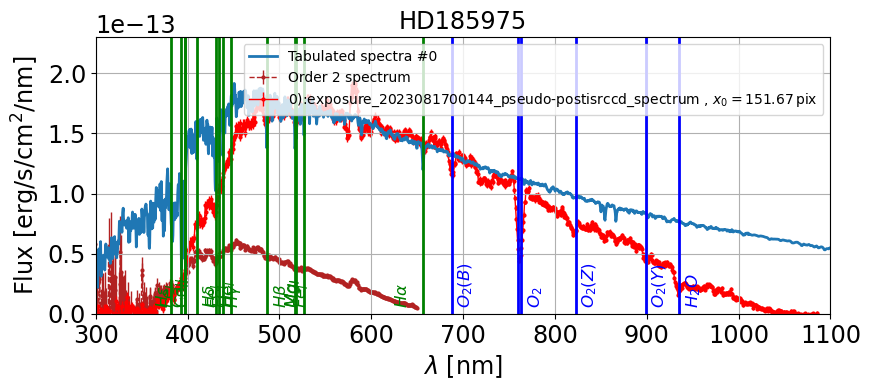

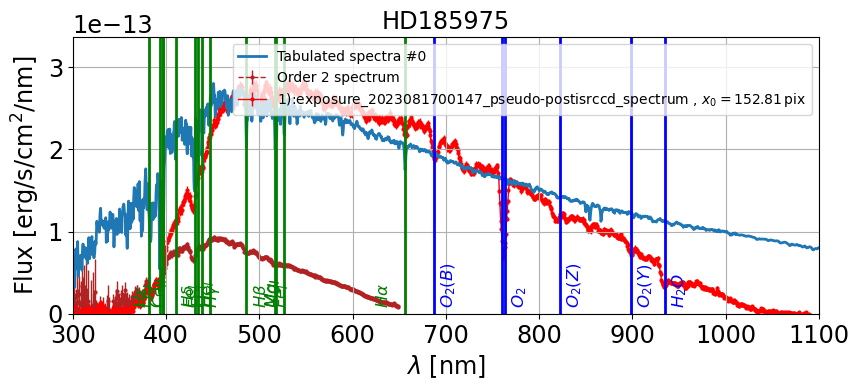

In [99]:
parameters.DISPLAY=True

FLAG_ORDER2 = False

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     

    s=Spectrum(fullfilename,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    try:
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    except Exception as exc:
        print(exc)
    
    #print("=== ORIGINAL CALIB lines === ")
    #s.lines.print_detected_lines(print_table=True)
    
    
    
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    
    
    
    #ax2 = fig.add_subplot(1, 2, 2)
    #parameters.REBIN=1
    #s.plot_spectrogram(ax=ax2,scale="log")
    
    #plt.show()
        
        
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
  
    all_figs.append(fig)
    
    idx+=1
    

## Save figures in a pdf filename

In [100]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        #s=Spectrum(fullfilename, config=config,fast_load=False);
        s=Spectrum(fullfilename,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        #ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
        #s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [101]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [102]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        

### Individual spectra

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/1.0, idx_inpage = 1, idx_fig = 1


FileNotFoundError: [Errno 2] No such file or directory: './figures_process_20230817_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_1/HD185975_spectrum.pdf'

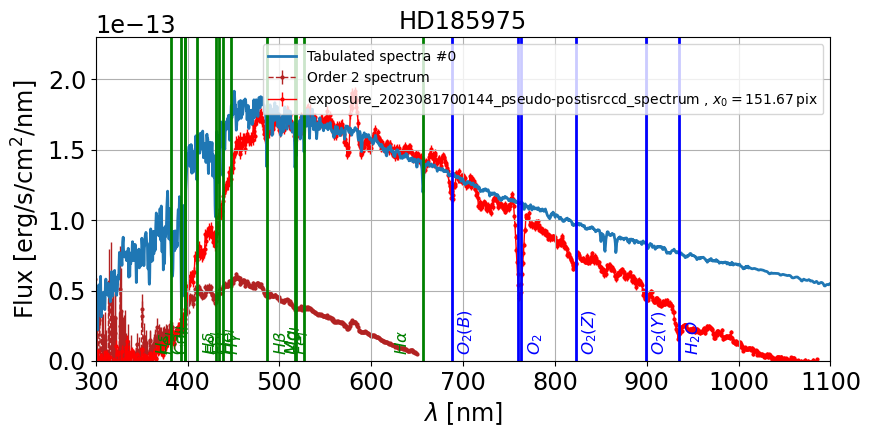

In [103]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

### Summary spectra

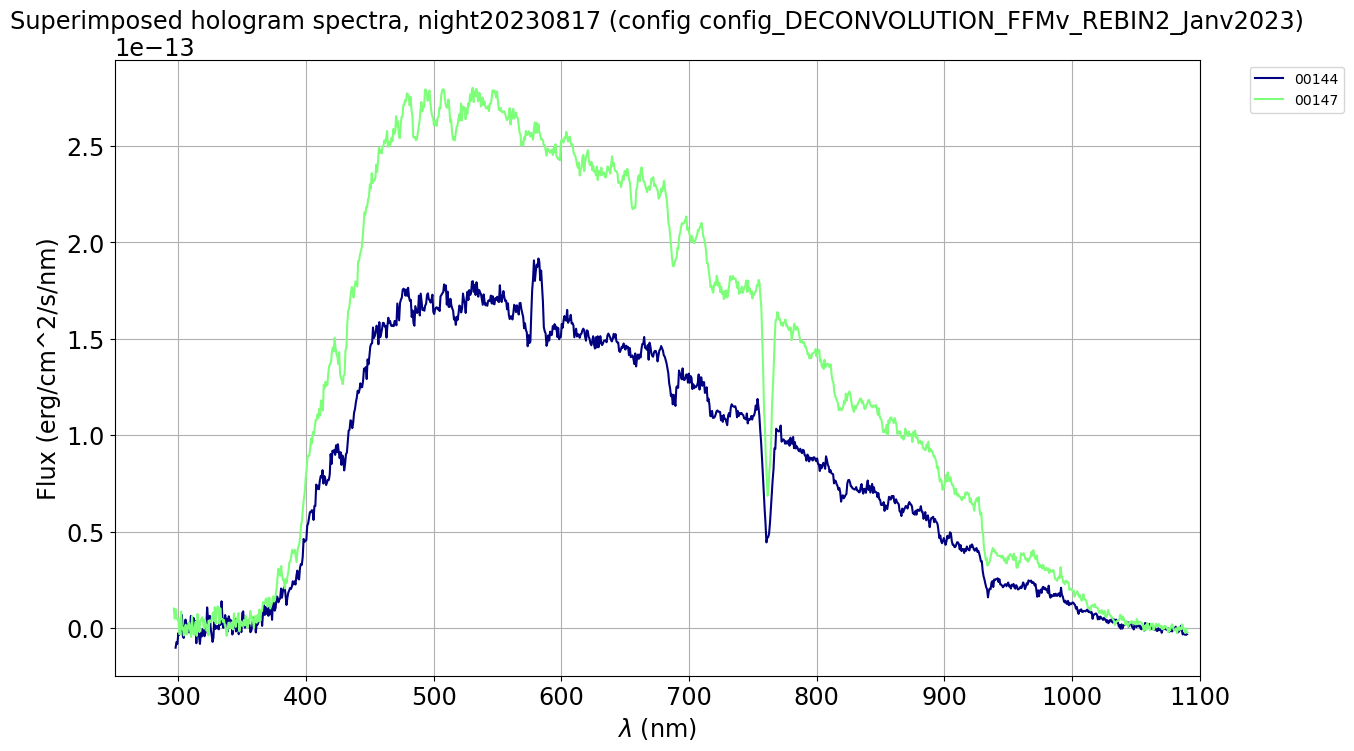

In [104]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [105]:
all_figs.append(sumfig)

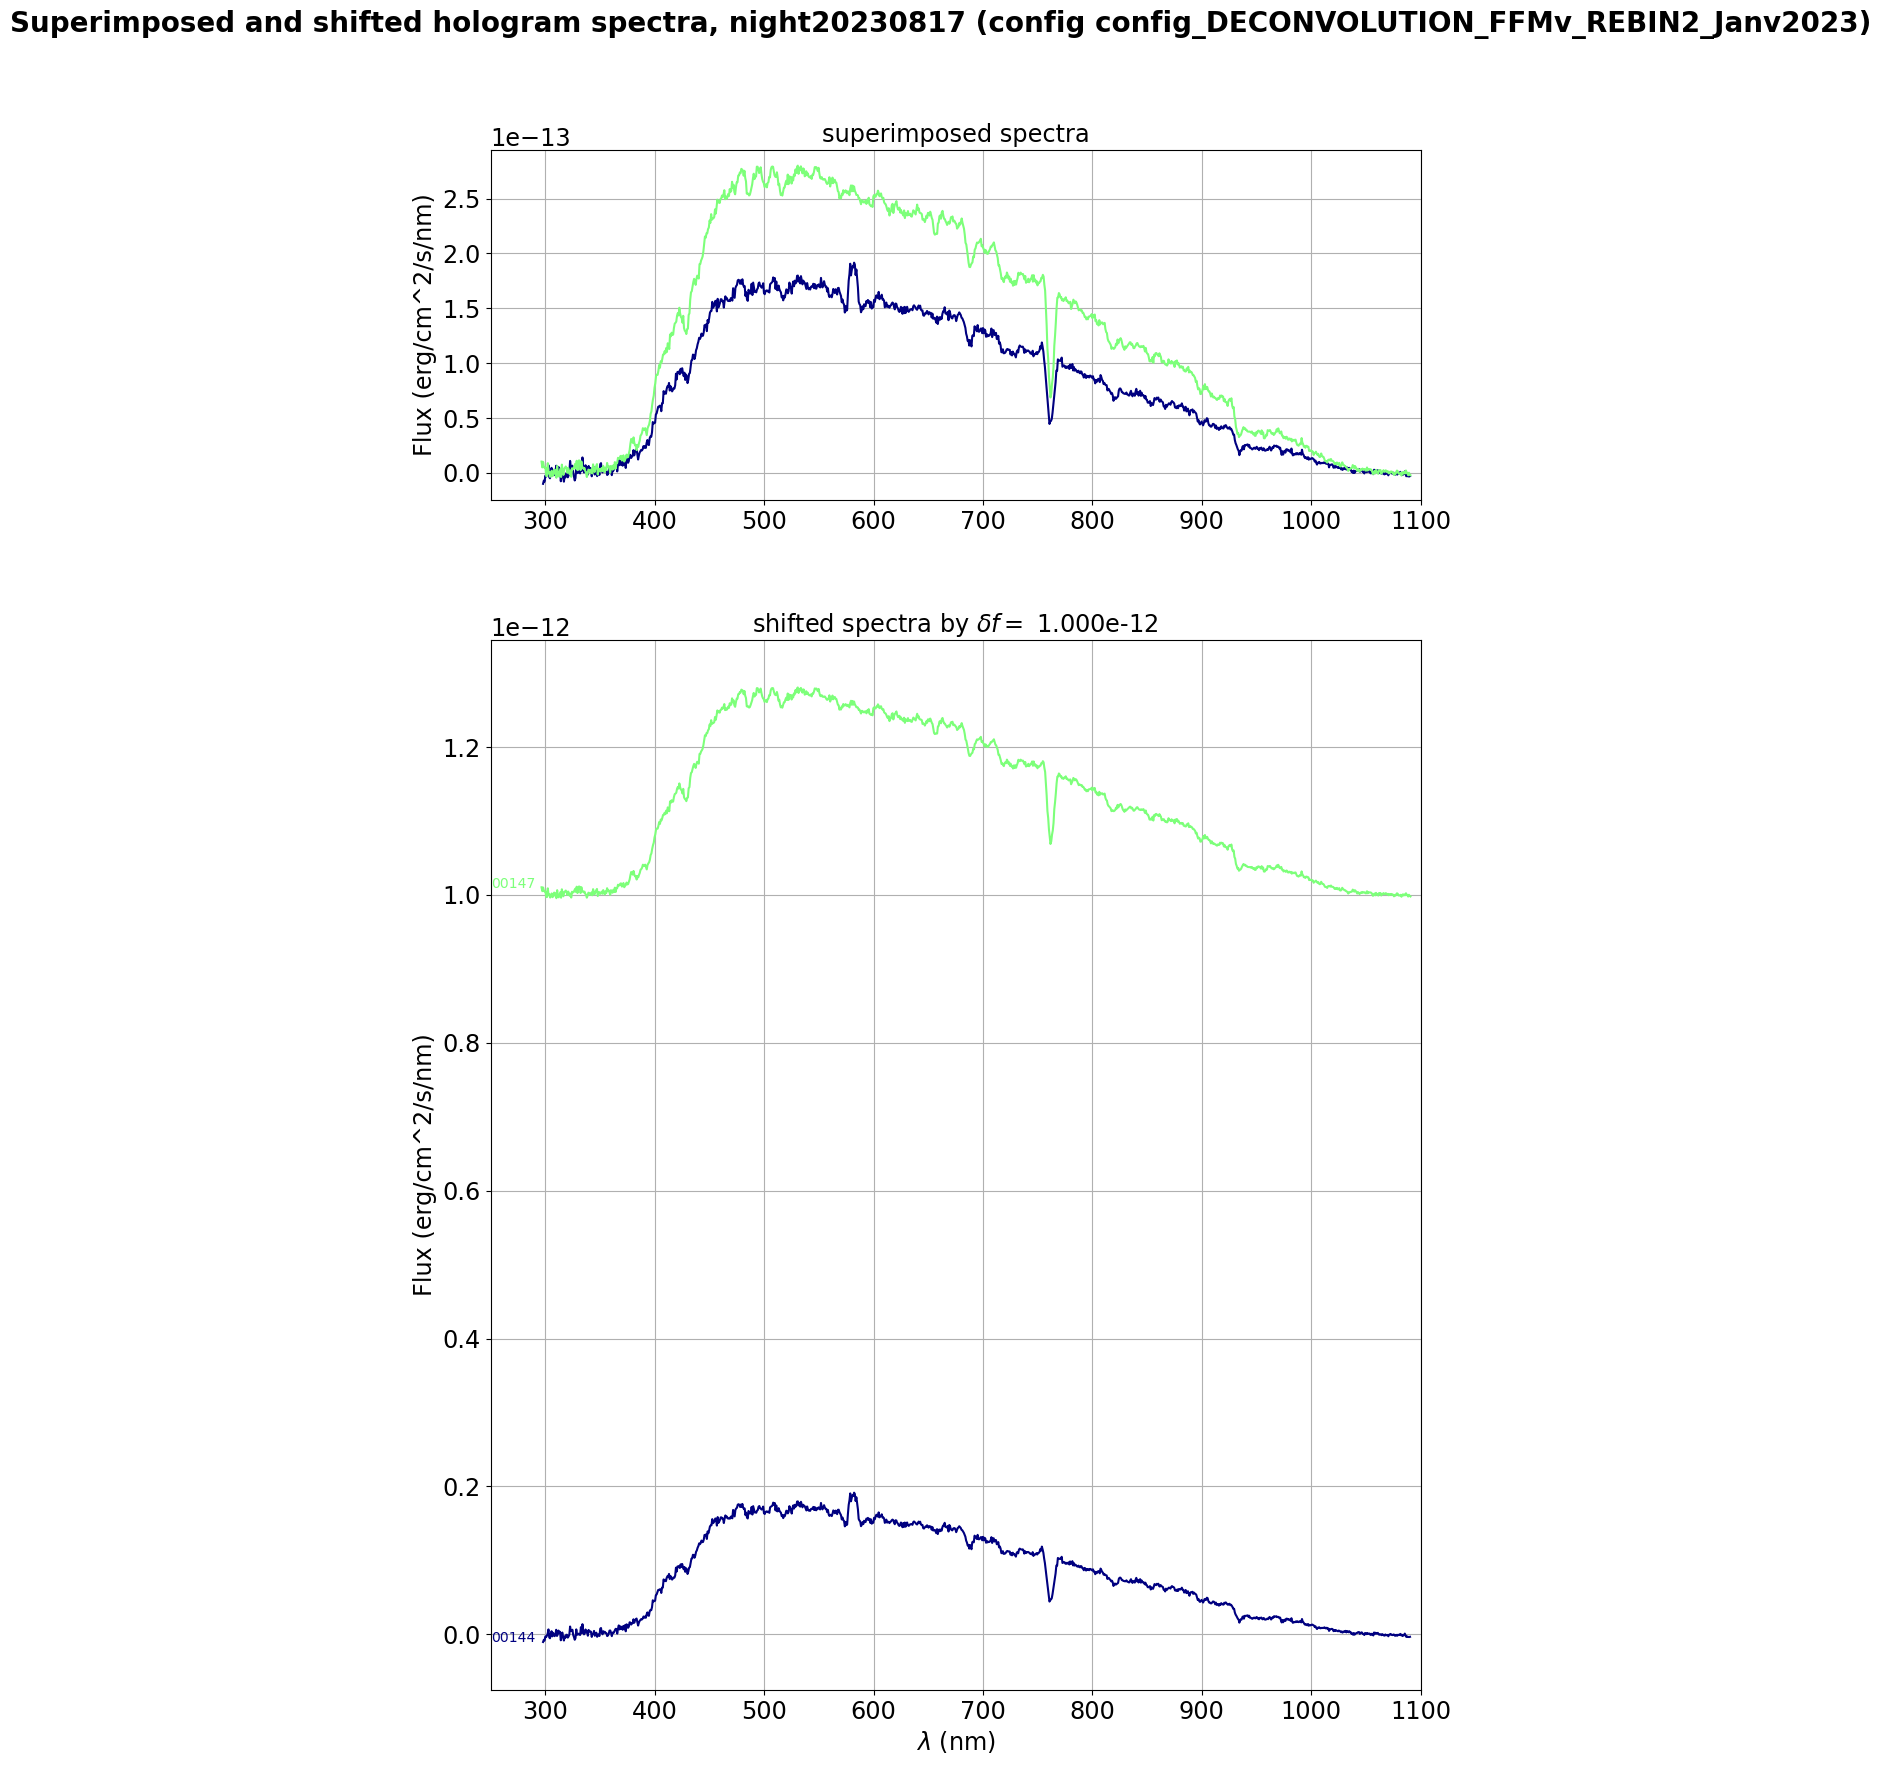

In [106]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [107]:
all_figs.append(sumfig2)

### Save in pdf file

In [ ]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

0 ) exposure_2023081700144_pseudo-postisrccd_spectrum.fits   /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec/exposure_2023081700144_pseudo-postisrccd_spectrum.fits
[Errno 2] No such file or directory: './figures_process_20230817_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_1/HD185975_spectrum.pdf'


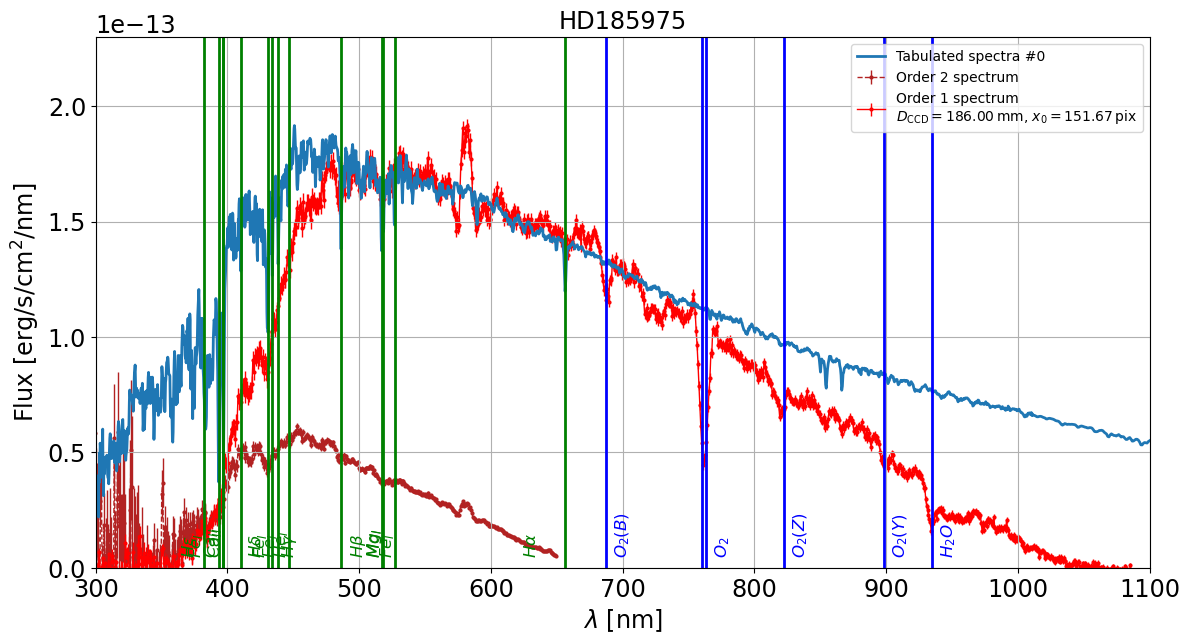

In [108]:
idx=0

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
#s=Spectrum(fullfilename, config=config,fast_load=False)
s=Spectrum(fullfilename,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
try:
    s.plot_spectrum(ax=ax1,force_lines=True)
except Exception as exc:
    print(exc)
#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

In [109]:
all_figs.append(fig)

## Info

In [110]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [111]:
df_infos.set_index('idx',inplace=True)

In [112]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [113]:
all_reftime=np.array(all_reftime)

In [114]:
df_infos["reftime"]=all_reftime

In [115]:
NN = len(df_infos)

In [116]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD185975,2023-08-17T23:42:34.531,1.903331,4.05,741.950012,39.362499,0.000000
1,HD185975,2023-08-17T23:44:26.476,1.902132,4.15,741.950012,34.474998,0.031096


In [117]:
configmode

'FFMv_REBIN2_Janv2023'

In [118]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

Text(0.5, 1.0, 'airmassvs vs date')

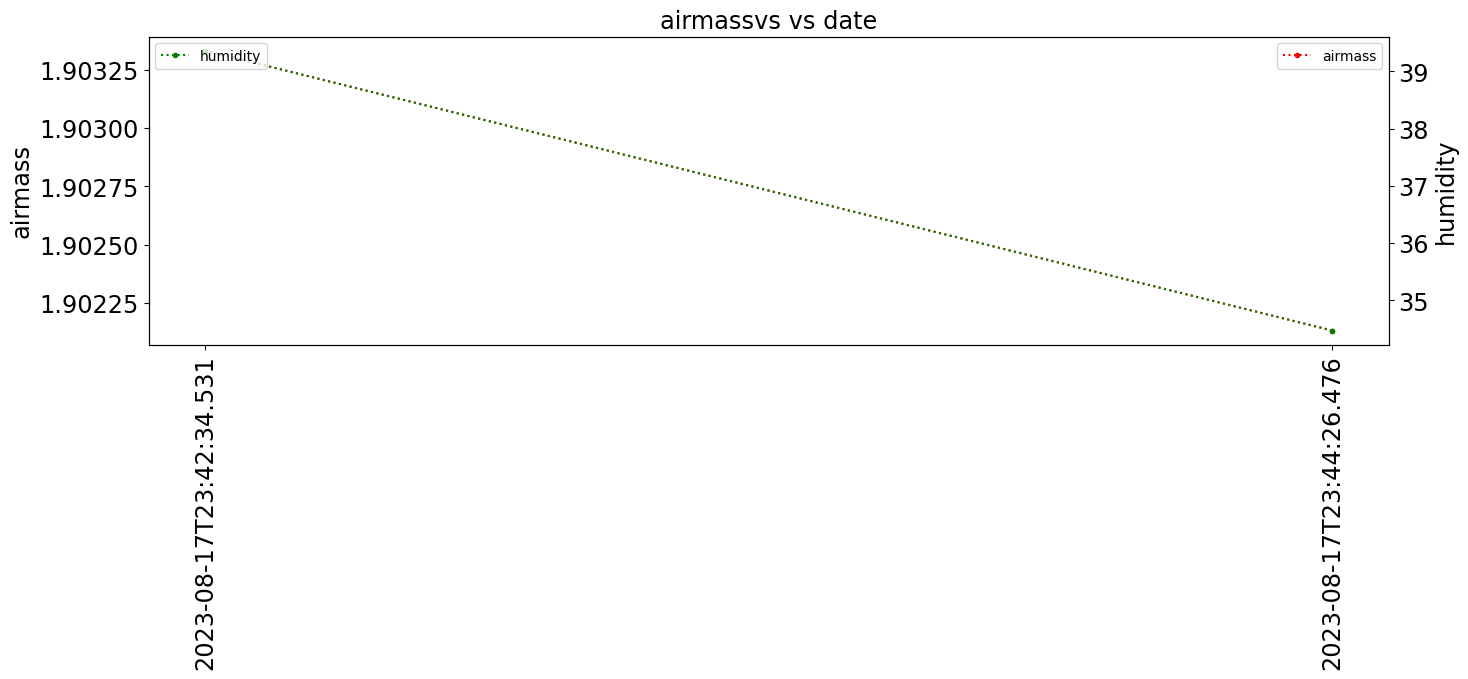

In [119]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

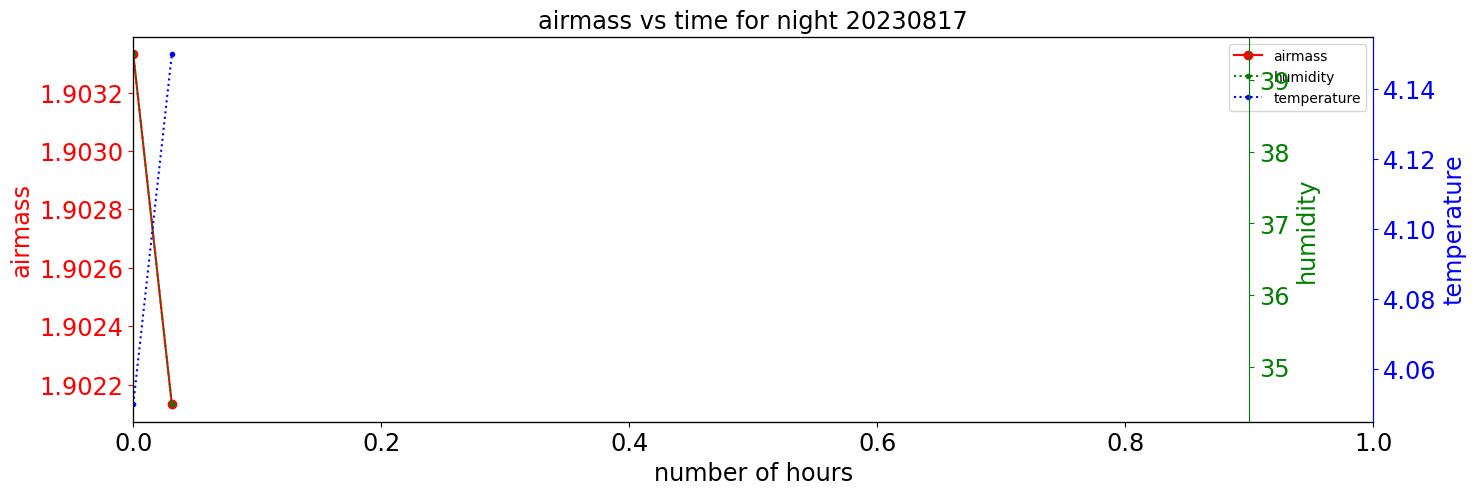

In [120]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [121]:
all_figs.append(fig)

# Header info

In [122]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [123]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1136                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
DETSIZE = '[1:4072,1:4000]'                                                     
BINX    =                    1                                                  
BINY    =                    1                                                  
CCDGAIN =                  1.0                                                  
CCDNOISE=                 10

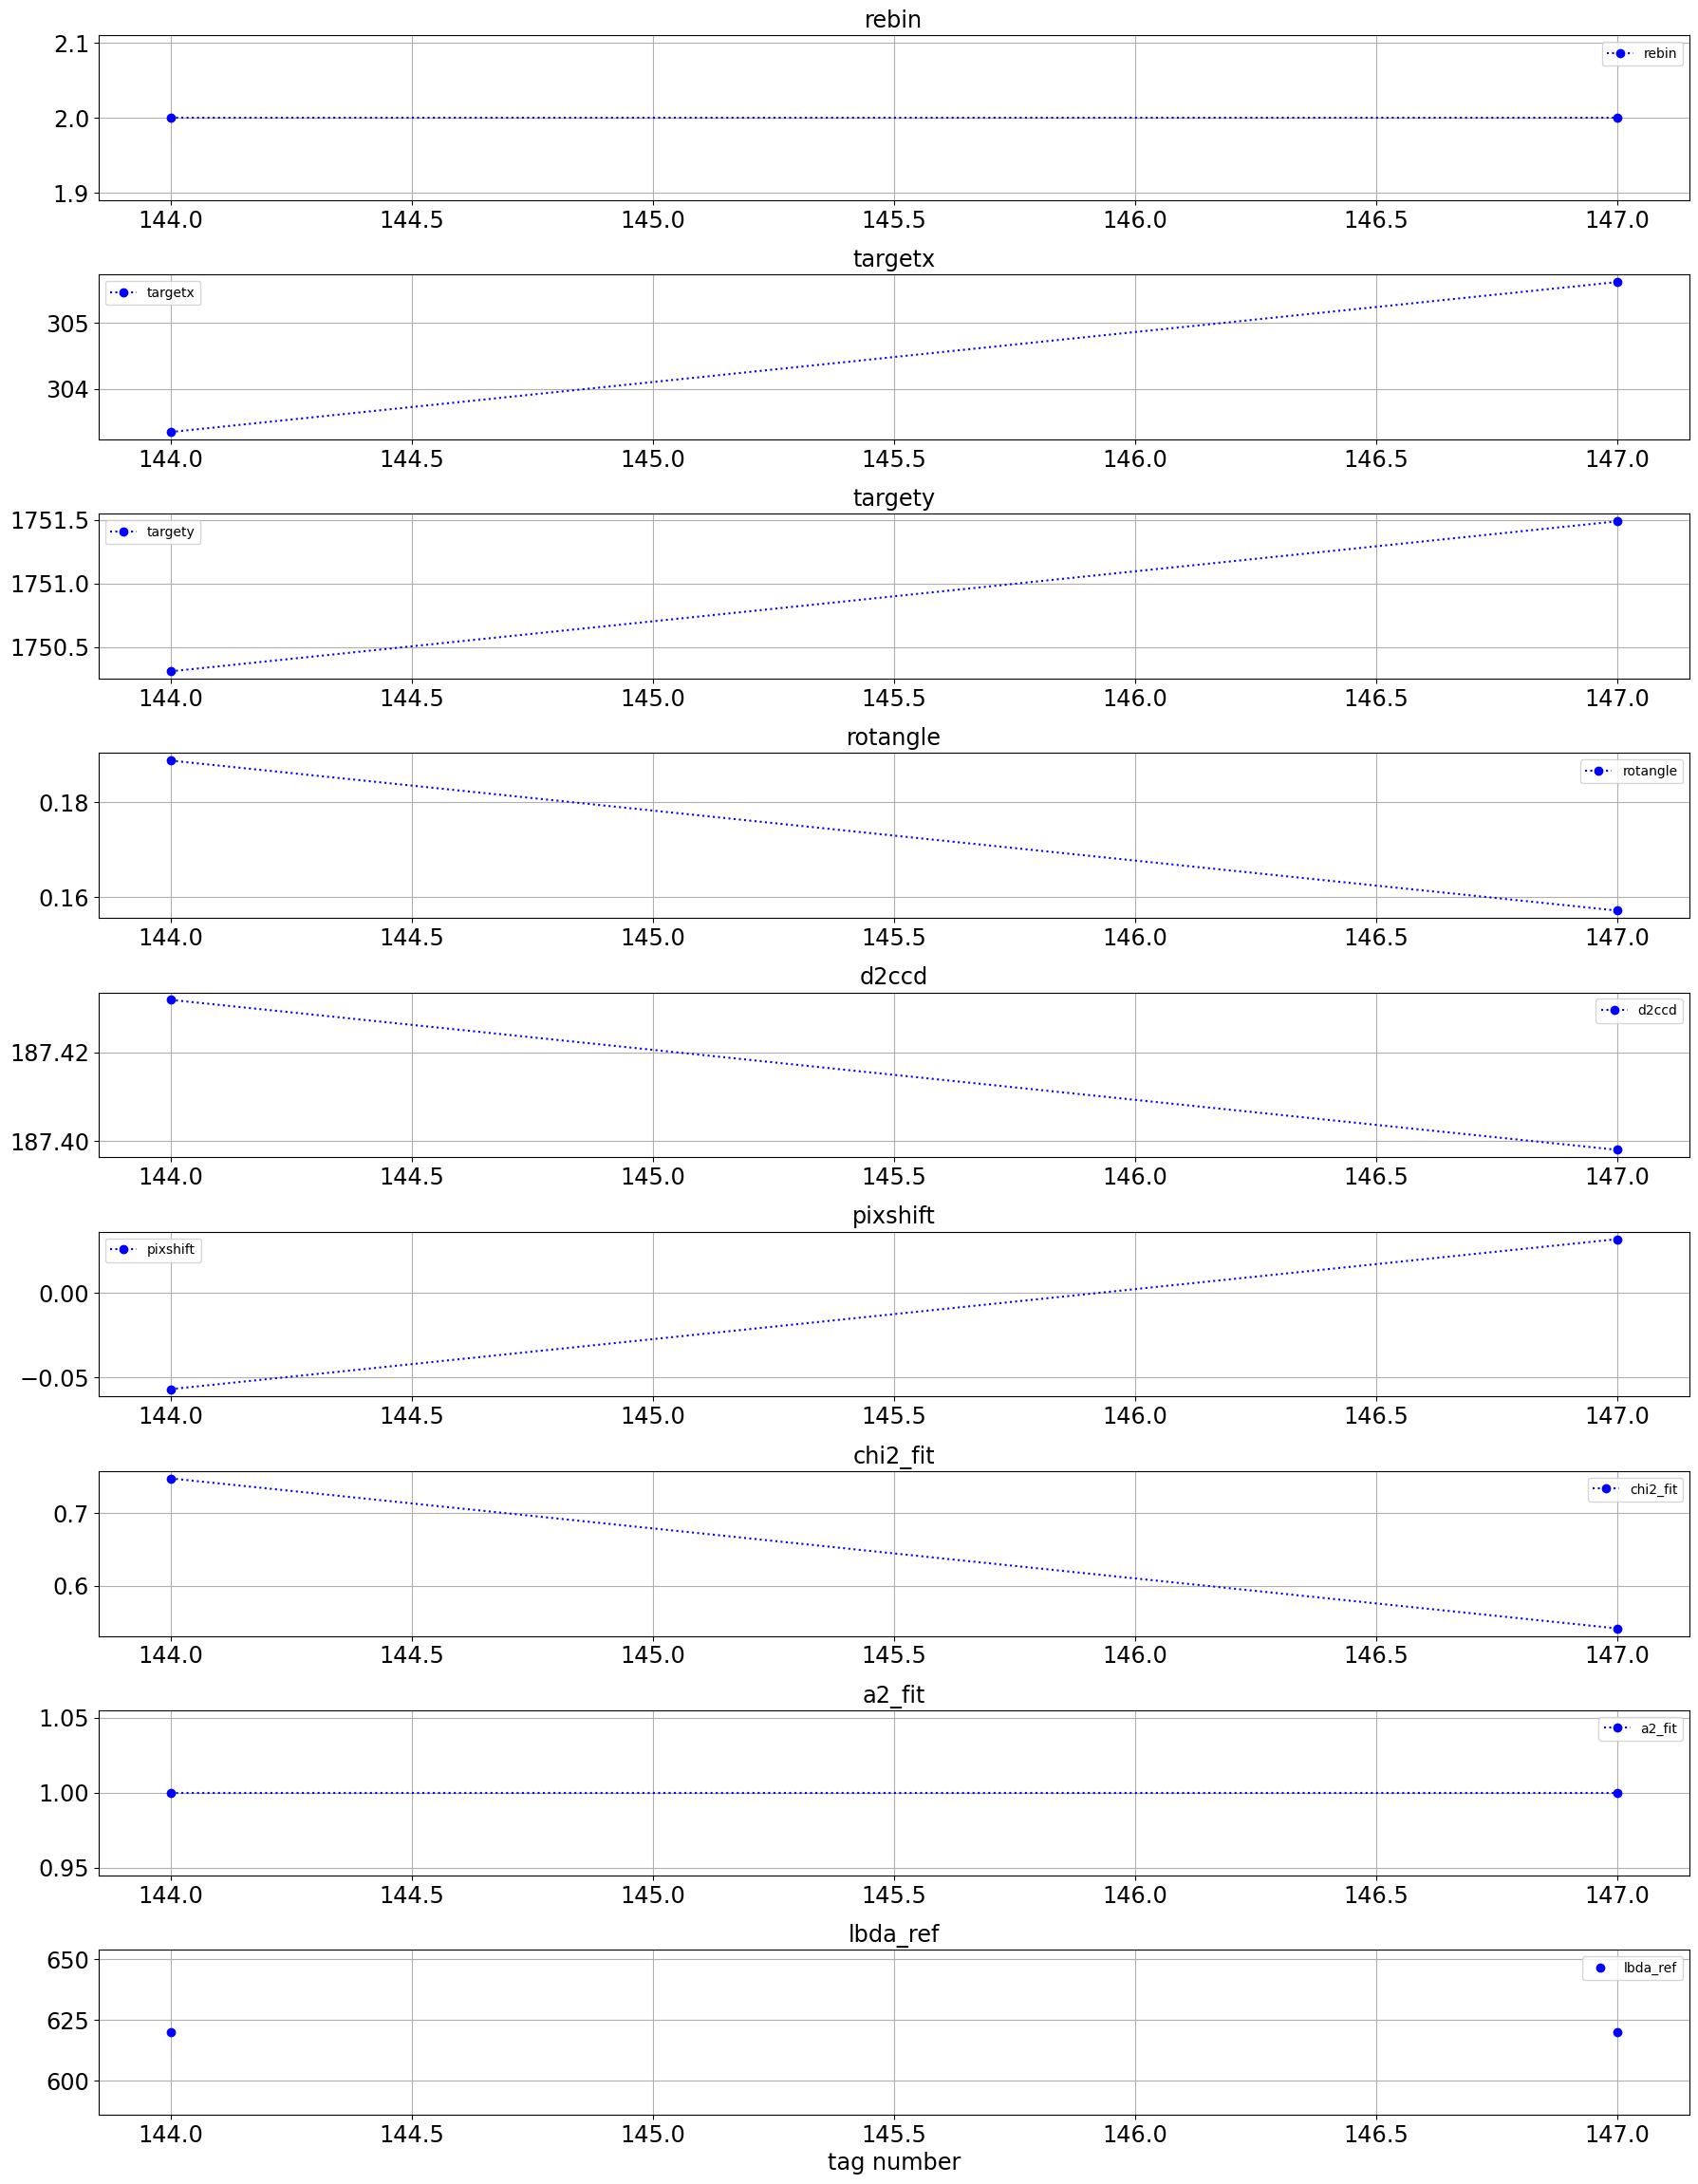

In [124]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [125]:
all_figs.append(fig)

# Write in pdf file

In [126]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [127]:
 multipage_pdf_file

'multipage_pdf_holo-20230817-empty~holo4_003-config_DECONVOLUTION_FFMv_REBIN2_Janv2023.pdf'

# write in pickles files

In [128]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [129]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [130]:
pkl_infilename=pkl_outfilename

In [131]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [132]:
#content

In [133]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2023081700144_pseudo-postisrccd_spectrum.fits',
 {'number': 144.0,
  'object': 'HD185975',
  'dateobs': '2023-08-17T23:42:34.531',
  'refhour': 0.0,
  'airmass': 1.903331368739209,
  'pressure': 741.9500122070312,
  'temperature': 4.050000190734863,
  'humidity': 39.36249923706055,
  'targetx_pix': 303.34685327851986,
  'targety_pix': 1750.309222518063,
  'rotangle': 0.18881741627485288,
  'd2ccd': 187.43181706574995,
  'all_lambdas': array([ 297.86801798,  298.57361468,  299.27923213, ..., 1088.87407064,
         1089.55736237, 1090.24061911]),
  'all_fluxes': array([-1.02546683e-14, -7.34150756e-15, -8.25352502e-15, ...,
         -3.52094384e-15, -3.55387010e-15, -3.24842800e-15]),
  'all_fluxes_err': array([1.19010017e-14, 9.98801266e-15, 7.27750168e-15, ...,
         1.28775462e-15, 1.66258580e-15, 1.99193254e-15])})